In [41]:
# standard library imports
import csv
import ast
import datetime as dt
import json
import os
import statistics
import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# third-party imports
import numpy as np
import pandas as pd

import requests
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pip freeze > requirements.txt For Updating requirements.txt

In [ ]:
np.random.seed(0)

<h3>Helper Function</h3>

In [2]:
def covnertDateTime(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    return dataframe

In [57]:
holidays_events = covnertDateTime(pd.read_csv('holidays_events.csv'))
trainning_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
stores_data = pd.read_csv('stores.csv')
transaction_data = covnertDateTime(pd.read_csv('transactions.csv'))
oil_data = covnertDateTime(pd.read_csv('oil.csv'))


In [4]:
print("\n Store Data:")
display(stores_data.head(5))

print("\n Holiday Data:")
display(holidays_events.head(5))

print("\n Transaction Data:")
display(transaction_data.head(5))

print("\n Oil Data:")
display(oil_data.head(5))


 Store Data:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



 Holiday Data:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



 Transaction Data:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



 Oil Data:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
trainning_data_store_sales = pd.concat([x for x in pd.read_csv('train.csv',
    parse_dates=['date'],
    chunksize=1000
)], ignore_index=True)

trainning_data_store_sales['sales'] = pd.to_numeric(trainning_data_store_sales['sales'], errors="coerce")
## For Testing
trainning_data_store_sales_backup = trainning_data_store_sales

In [6]:
test = pd.concat([x for x in pd.read_csv('test.csv',
    # dtype={
    #     'store_nbr': 'category',
    #     'family': 'category',
    #     'onpromotion': 'uint32',
    # },
    parse_dates=['date'],
    chunksize=1000

)], ignore_index=True)

## For Testing
test_backup = test


# step_count
# dir(step_count)
# test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

Convert to DateTime for processing

In [7]:
trainning_data_store_sales['date'] = pd.to_datetime(trainning_data_store_sales['date'])

<h3>Step 2: Overview</h3>

Distribution Overview

<Axes: xlabel='sales', ylabel='Count'>

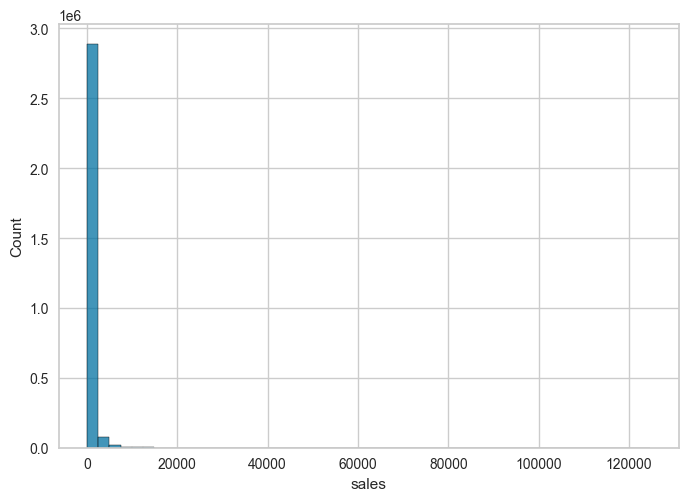

In [8]:
# sns.lineplot(data=trainning_data_store_sales, x="sales", y="date")
sns.histplot(trainning_data_store_sales['sales'], bins=50)

Trend of sales

In [ ]:
plot_params = {'color': '0.75','style': '.-','markeredgecolor': '0.25','markerfacecolor': '0.25','legend': False}

In [ ]:
average_sale = trainning_data_store_sales.groupby('date').mean('sales')

In [ ]:
average_sale_by_date = trainning_data_store_sales.groupby('date').mean('sales')['sales']

In [ ]:
#  Plot: Overall Sales Trend Over Time
# trend = average_sale.rolling(
#     window=365,
#     center=True,
#     min_periods=183,
# ).mean()


fig = px.scatter(title="Trend of overall Sale",data_frame=average_sale_by_date, x=average_sale_by_date.index, y=average_sale_by_date.values, trendline="rolling", trendline_options=dict(window=365))
fig.data[1].update(line_color='red') 
fig.update_layout(
    xaxis_title="Time", yaxis_title="Sale"
)
fig.show()

### Using matplotlib
# plt.plot(average_sale.index, average_sale.values)
# plt.xlabel("Time",  size = 20)
# plt.ylabel("Sales", size = 20)
# plt.title("Trend Sales", size = 25)

# plt.plot(trend, color="red")


Overview of Sale by Store

In [ ]:
merged_train_store_data = pd.merge(left=trainning_data_store_sales, right=stores_data, on='store_nbr')
display(merged_train_store_data.head(5))
display(trainning_data_store_sales.head(5))
display(stores_data.head(5))

In [ ]:
fig = px.box(merged_train_store_data, x="type", y="sales")
fig.show()

# Type D seems to have the highest sales overall.
# Box plot shows flat line because we are 

In [ ]:
average_sale_store_nbr = trainning_data_store_sales.groupby('store_nbr').mean('sales')['sales']

In [ ]:
fig = px.bar(title="Overall Sale based on Store", data_frame=average_sale_store_nbr, x=average_sale_store_nbr.index, y=average_sale_store_nbr.values)
fig.update_layout(
    xaxis_title="Store Id", yaxis_title="Sale"
)
fig.show()

# Store number 44 seems to have the highest sale. The plot indicates right-side (upper number stores) have an overall better sale --> Location-wise might be important?

<h3>Step 3: Check Seasonality</h3>

In [ ]:
seasonal_data = trainning_data_store_sales
date = trainning_data_store_sales['date']
seasonal_data['month'] = date.dt.month
seasonal_data['year'] = date.dt.year


sale_based_on_month = seasonal_data.groupby(['year', 'month']).mean('sales')
# sale_based_on_month

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(data=sale_based_on_month, x='month', y='sales', hue='year',marker="o", palette="rainbow")
plt.xlabel("Month")
plt.ylabel("Mean of Sales")
plt.title("Overall Sale of Months")
plt.xticks(range(1, 13))
plt.grid(True)
# px.line(data_frame=sale_based_on_month, x='month', y='sales', color='year')


## 2017 seems to have the least fluctuation in terms of Sale (hovers around 450-500)
## 2015 had the massive jump in sale over times (from more than 250 at the beginning of the year --> 550 at the end of the year)

<h3>Step 4: External Factors (Oil)

In [ ]:
fig = px.line(data_frame=oil_data, x=oil_data['date'], y=oil_data['dcoilwtico'])

fig.update_layout(
    xaxis_title="Date", yaxis_title="Oil Values"
)
fig.show()


Oil seems to fluctuate quite randomly --> No real connection/correlation 

In [ ]:
merged_oil_data = pd.merge(left=trainning_data_store_sales, right=oil_data, on='date').dropna()

In [ ]:
fig = px.scatter(data_frame=merged_oil_data, y=merged_oil_data['dcoilwtico'], x=merged_oil_data['sales'])

fig.update_layout(
    xaxis_title="Sales", yaxis_title="Oil Values"
)
fig.show()

In [ ]:
oil_data.isnull().sum()

Clean up missing values for Oil (missing 43 values)

In [ ]:
oil_data['dcoilwtico'].ffill(inplace=True)
# Default to fill the missing values in the oil data

<h3>Step 5: Merge external data (Oil)</h3>


In [ ]:
trainning_data['date'] = pd.to_datetime(trainning_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])

trainning_data = pd.merge(trainning_data, oil_data, on='date', how='left')

trainning_data['dcoilwtico'].ffill(inplace=True) 


           date   sales  dcoilwtico
1782 2013-01-02     2.0       93.14
1783 2013-01-02     0.0       93.14
1784 2013-01-02     2.0       93.14
1785 2013-01-02  1091.0       93.14
1786 2013-01-02     0.0       93.14


/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_2308/3191831838.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainning_data['dcoilwtico'].ffill(inplace=True)


Trend of oil and sales

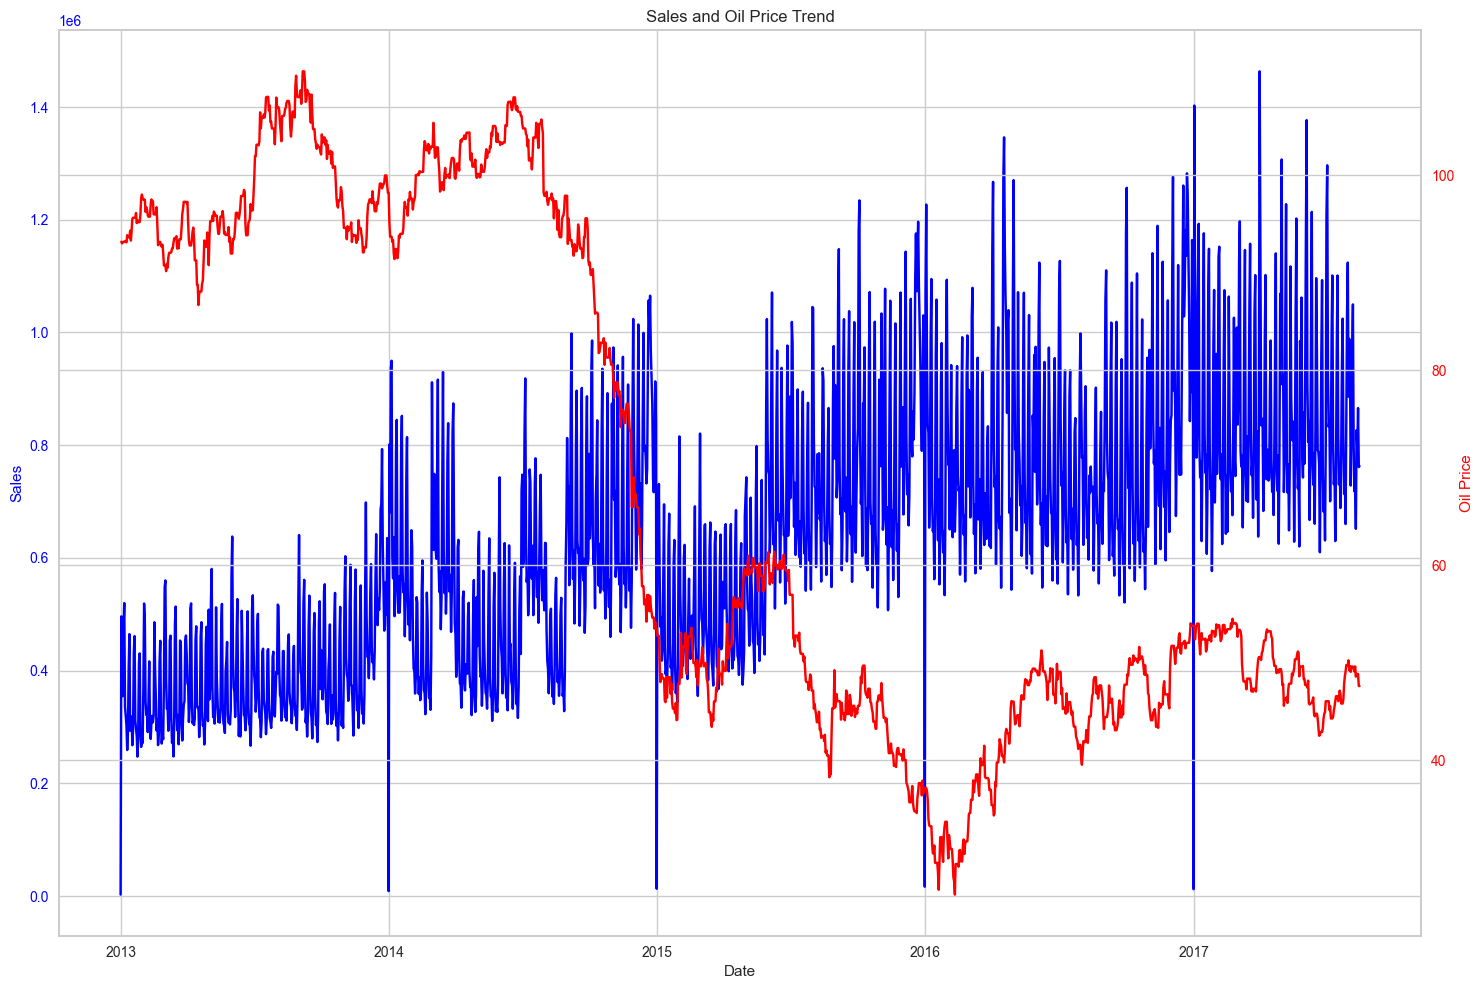

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 10))

# Sale trend
ax1.plot(trainning_data.groupby('date')['sales'].sum(), color='blue', label='Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Oil price trend
ax2 = ax1.twinx()
ax2.plot(trainning_data['date'], trainning_data['dcoilwtico'], color='red', label='Oil Price')
ax2.set_ylabel('Oil Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.title('Sales and Oil Price Trend')
plt.show()

No real indicatation of the sales and oil prices related to each other

<h3> Step 6: Train Model </h3>

In [58]:
trainning_data['date'] = pd.to_datetime(trainning_data['date'])

## Feature Engineering
trainning_data['day'] = trainning_data['date'].dt.day
trainning_data['month'] = trainning_data['date'].dt.month
trainning_data['year'] = trainning_data['date'].dt.year
trainning_data['dayofweek'] = trainning_data['date'].dt.dayofweek
trainning_data['weekofyear'] = trainning_data['date'].dt.isocalendar().week


In [59]:
features = ['store_nbr','day', 'month', 'year', 'dayofweek', 'weekofyear']
target = ['sales']


# drop all rows with missing values from features and target sales
trainning_data.dropna(subset=features + target, inplace=True)

In [60]:
# Train test split
np.random.seed(0)
X_train, X_val, y_train, y_val = train_test_split(trainning_data[features], trainning_data[target], test_size=0.2, random_state=4)

# Checking shape before doing things
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (2400710, 6)
X_val shape: (600178, 6)


In [61]:
#  Train XGBoost Model
xgboost_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, early_stopping_rounds=50)

xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-rmse:1101.50587
[50]	validation_0-rmse:1070.89944
[100]	validation_0-rmse:1068.94349
[150]	validation_0-rmse:1068.10985
[200]	validation_0-rmse:1067.76336
[250]	validation_0-rmse:1067.58850
[300]	validation_0-rmse:1067.54789
[350]	validation_0-rmse:1067.55677
[365]	validation_0-rmse:1067.55763


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [62]:
#  XGBoost Predictions & Evaluation
y_pred_xgb = np.maximum(xgboost_model.predict(X_val), 0) # convert all positive numbers
rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb)
print(f" XGBoost Model RMSE: {rmse_xgb:.5f}")

 XGBoost Model RMSE: 1067.52673


Test with LightGBM

In [ ]:
#  Merge External Data
oil_data.fillna(method='ffill', inplace=True)
train = trainning_data.merge(oil_data[['date', 'dcoilwtico']], on='date', how='left')
test = test.merge(oil_data[['date', 'dcoilwtico']], on='date', how='left')

#  Feature Engineering
train['day'] = train['date'].dt.day
test['day'] = test['date'].dt.day
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month
train['year'] = train['date'].dt.year
test['year'] = test['date'].dt.year
train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek


# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=42)

#  Train LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', callbacks=[lgb.early_stopping(50)])

#  LightGBM Predictions & Evaluation
y_pred_lgb = np.maximum(lgb_model.predict(X_val), 0)  # Ensure no negative values
rmse_lgb = root_mean_squared_error(y_val, y_pred_lgb)
print(f" LightGBM Model RMSE: {rmse_lgb:.4f}")

Compare Model

In [ ]:
#  Compare Models
print(f" LightGBM Model RMSE: {rmse_lgb:.4f}")
print(f" XGBoost Model RMSE: {rmse_xgb:.4f}")

# Select the best model based on RMSE (lower is better)
best_model = lgb_model if rmse_lgb < rmse_xgb else xgboost_model
print(" Best model selected for final predictions:", "LightGBM" if best_model == lgb_model else "XGBoost")

<h3> Step 7: Predicting <h3>

In [63]:
test_data['date'] = pd.to_datetime(test_data['date'])

## Feature Engineering
test_data['day'] = test_data['date'].dt.day
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data['dayofweek'] = test_data['date'].dt.dayofweek
test_data['weekofyear'] = test_data['date'].dt.isocalendar().week

# Merge external oil data:
test_data = test_data.merge(oil_data[['date', 'dcoilwtico']], on='date',how='left')

# Remove all missing values
test_data.ffill(inplace=True)

test_data.head()

,id,date,store_nbr,family,onpromotion,day,month,year,dayofweek,weekofyear,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,16,8,2017,2,33,46.8
1,3000889,2017-08-16,1,BABY CARE,0,16,8,2017,2,33,46.8
2,3000890,2017-08-16,1,BEAUTY,2,16,8,2017,2,33,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,16,8,2017,2,33,46.8
4,3000892,2017-08-16,1,BOOKS,0,16,8,2017,2,33,46.8


Final Merge of both train and test for splitting

In [64]:
oil_data.ffill(inplace=True)
final_train = trainning_data.merge(oil_data[['date', 'dcoilwtico']], on='date', how='left')
final_test = test_data.merge(oil_data[['date', 'dcoilwtico']], on='date', how='left')

In [65]:
for joined in [final_train, final_test]: 
    joined['day'] = joined['date'].dt.day
    joined['month'] = joined['date'].dt.month
    joined['year'] = joined['date'].dt.year
    joined['dayofweek'] = joined['date'].dt.dayofweek
    joined['weekofyear'] = joined['date'].dt.isocalendar().week

print("Train Columns:", final_test.columns)
print("Test Columns:", final_test.columns)

Train Columns: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'day', 'month',
       'year', 'dayofweek', 'weekofyear', 'dcoilwtico_x', 'dcoilwtico_y'],
      dtype='object')
Test Columns: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'day', 'month',
       'year', 'dayofweek', 'weekofyear', 'dcoilwtico_x', 'dcoilwtico_y'],
      dtype='object')


In [67]:
# Add oil to features
updateFeatures = features.append('dcoilwtico')
print("Features", features)
print("Target", target)

Features ['store_nbr', 'day', 'month', 'year', 'dayofweek', 'weekofyear', 'dcoilwtico']
Target ['sales']


In [69]:
#  Remove Missing Values Before Splitting
final_train.dropna(subset=features + target, inplace=True)

#  Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(final_train[features], final_train[target], test_size=0.2, random_state=42)


xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

#  Make Predictions
y_pred_xgb = np.maximum(xgb_model.predict(X_val), 0)
rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb)
print(f" XGBoost Model RMSE: {rmse_xgb:.5f}")

[0]	validation_0-rmse:972.86873
[50]	validation_0-rmse:948.32393
[100]	validation_0-rmse:946.91986
[150]	validation_0-rmse:946.26715
[200]	validation_0-rmse:946.13019
[250]	validation_0-rmse:946.06490
[298]	validation_0-rmse:946.11215
 XGBoost Model RMSE: 946.05603


<h3> Result </h3>

In [70]:
result_data = test_data
result_data.ffill(inplace=True)
result_data.dropna(subset=features, inplace=True)

# Prediction
result_data['sales'] = np.maximum(xgb_model.predict(result_data[features]), 0)

In [72]:
result_data.head(5)
result_data[['id', 'sales']].to_csv('submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Submission using XGBoost"